In [2]:
import numpy as np
import pandas as pd

from sklearn.gaussian_process.kernels import Matern, RBF
from sklearn.cluster import KMeans

from doc.mse_estimator import ErrorComparer
from doc.data_generation import gen_rbf_X, gen_matern_X, create_clus_split, gen_cov_mat
from doc.plotting_utils import gen_model_barplots

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from tqdm import tqdm

## Setup

In [3]:
np.random.seed(1)

In [4]:
## number of realizations to run
niter = 100

## data generation parameters
n=40**2
p=30
s=30
delta = 0.75
snr = 0.4
tr_frac = .5
gsize = 20

noise_kernel = 'matern'
noise_length_scale = 5.#1.
noise_nu = .5

X_kernel = 'matern'
X_length_scale = 5.
X_nu = 2.5

est_names = ["KFCV", "SPCV", "BLOOCV"]

In [5]:
nx = ny = int(np.sqrt(n))
xs = np.linspace(0, gsize, nx)
ys = np.linspace(0, gsize, ny)
c_x, c_y = np.meshgrid(xs, ys)
c_x = c_x.flatten()
c_y = c_y.flatten()
coord = np.stack([c_x, c_y]).T

In [6]:
if noise_kernel == 'rbf':
    Sigma_t = gen_cov_mat(c_x, c_y, RBF(length_scale=noise_length_scale))
elif noise_kernel == 'matern':
    Sigma_t = gen_cov_mat(c_x, c_y, Matern(length_scale=noise_length_scale, nu=noise_nu))
else:
    Sigma_t = np.eye(n)
    
Cov_st = delta*Sigma_t
Sigma_t = delta*Sigma_t + (1-delta)*np.eye(n)

if noise_kernel == 'rbf' or noise_kernel == 'matern':
    Chol_t = np.linalg.cholesky(Sigma_t)
else:
    Chol_t = np.eye(n)

## Generate Gaussian X, Y

In [7]:
if X_kernel == 'rbf':
    X = gen_rbf_X(c_x, c_y, p)
elif X_kernel == 'matern':
    X = gen_matern_X(c_x, c_y, p, length_scale=X_length_scale, nu=X_nu)
else:
    X = np.random.randn(n,p)

beta = np.zeros(p)
idx = np.random.choice(p,size=s,replace=False)
beta[idx] = np.random.uniform(-1,1,size=s)

In [8]:
Chol_t *= np.std(X@beta) / np.sqrt(snr)

In [9]:
Y = X @ beta + Chol_t @ np.random.randn(n)

## Compute expected correction for one fold of CV vs expected correction for random sample

In [10]:
## assuming linear model, and bias approx 0
def computeCorrection(
    S, 
    Sigma, 
    tr_idx, 
    ts_idx=None,
):
    if ts_idx is None:
        ts_idx = ~tr_idx

    return (Sigma[ts_idx,ts_idx].sum() - 2*np.diag(S @ Sigma[tr_idx,:][:,ts_idx]).sum()) / ts_idx.sum()

In [11]:
def getDistance(c_x, c_y):
    Loc = np.stack([c_x, c_y]).T
    m = np.sum(Loc**2, axis=1)
    D = (-2 * Loc.dot(Loc.T) + m).T + m
    D = 0.5 * (D + D.T)
    D = np.maximum(D, 0)  ## sometimes gets values like -1e-9
    D = np.sqrt(D)
    
    return D    

def getBufferTrain(D, tr_bool, ts_idx):
    buffer_tr_bool = tr_bool & (D[ts_idx,:] > 10)
    return buffer_tr_bool

In [12]:
D = getDistance(c_x, c_y)

In [13]:
kfcv_corr = np.zeros(100)
spcv_corr = np.zeros(100)
bloocv_corr = np.zeros(100)
ns_corr = np.zeros(100)
sp_corr = np.zeros(100)

for i in tqdm(range(100)):
    idxs = np.random.choice(n, size=int(.3*n), replace=False)
    cv_tr_idx = idxs[:int(.16*n)]
    cv_tr_bool = np.zeros(n, dtype=bool)
    cv_tr_bool[cv_tr_idx] = True

    cv_ts_idx = idxs[int(.16*n):int(.2*n)]
    cv_ts_bool = np.zeros(n, dtype=bool)
    cv_ts_bool[cv_ts_idx] = True

    tr_idx = idxs[:int(.2*n)]
    tr_bool = np.zeros(n, dtype=bool)
    tr_bool[tr_idx] = True

    ts_idx = idxs[int(.2*n):]
    ts_bool = np.zeros(n, dtype=bool)
    ts_bool[ts_idx] = True

    ## split into 3 folds by kmeans
    groups = KMeans(n_init=10, n_clusters=5).fit(coord[idxs[:int(.2*n)]]).labels_
    spcv_tr_idx = idxs[np.where(groups < 4)[0]]
    spcv_tr_bool = np.zeros(n, dtype=bool)
    spcv_tr_bool[spcv_tr_idx] = True
    spcv_ts_idx = idxs[np.where(groups == 4)[0]]
    spcv_ts_bool = np.zeros(n, dtype=bool)
    spcv_ts_bool[spcv_ts_idx] = True

    ## pick one point for ts, tr is all far enough away
    bloocv_tr_idx = idxs[np.random.choice(len(idxs),size=len(idxs),replace=False)]
    bloocv_ts_idx = bloocv_tr_idx[0]

    bloocv_tr_bool = np.zeros(n, dtype=bool)
    bloocv_tr_bool[bloocv_tr_idx] = True
    bloocv_tr_bool = getBufferTrain(D, bloocv_tr_bool, bloocv_ts_idx)

    bloocv_ts_bool = np.zeros(n, dtype=bool)
    bloocv_ts_bool[bloocv_ts_idx] = True

    # X = gen_rbf_X(c_x, c_y, p)
    # X = gen_matern_X(c_x, c_y, p, length_scale=X_length_scale, nu=X_nu)
    Y = X@beta + Chol_t @ np.random.randn(n)
    
    X_cv = X[cv_tr_idx,:]
    S_cv = X[cv_ts_idx,:] @ np.linalg.pinv(X_cv)

    X_spcv = X[spcv_tr_idx,:]
    S_spcv = X[spcv_ts_idx,:] @ np.linalg.pinv(X_spcv)

    X_bloocv = X[bloocv_tr_bool,:]
    S_bloocv = X[bloocv_ts_idx,:] @ np.linalg.pinv(X_bloocv)

    
    X_tr = X[tr_idx,:]
    S_tr = X[ts_idx,:] @ np.linalg.pinv(X_tr)

    sp_idx = np.random.choice(ts_idx,size=1)
    sp_bool = np.zeros(n, dtype=bool)
    sp_bool[sp_idx] = True
    S_sp = X[sp_idx,:] @ np.linalg.pinv(X_tr)
    kfcv_corr[i] = computeCorrection(S_cv, Sigma_t, cv_tr_bool, cv_ts_bool)
    spcv_corr[i] = computeCorrection(S_spcv, Sigma_t, spcv_tr_bool, spcv_ts_bool)
    bloocv_corr[i] = computeCorrection(S_bloocv, Sigma_t, bloocv_tr_bool, bloocv_ts_bool)
    ns_corr[i] = computeCorrection(S_tr, Sigma_t, tr_bool, ts_bool)
    sp_corr[i] = computeCorrection(S_sp, Sigma_t, tr_bool, sp_bool)
    
corrs = pd.DataFrame({
    'KFCV': kfcv_corr, 
    'SPCV': spcv_corr, 
    'BLOOCV': bloocv_corr, 
})


  3%|▎         | 3/100 [00:00<00:03, 28.16it/s]

100%|██████████| 100/100 [00:02<00:00, 45.07it/s]


In [20]:
fig = gen_model_barplots(
    [[ns_corr, kfcv_corr, spcv_corr, bloocv_corr]], 
    [""], 
    est_names, 
    title="Train/Test Split: OLS Correction Term Comparisons", 
    has_elev_err=False
)
fig.show()

In [21]:
(corrs / ns_corr.mean()).mean()

KFCV      1.000865
SPCV      1.089865
BLOOCV    0.822150
dtype: float64

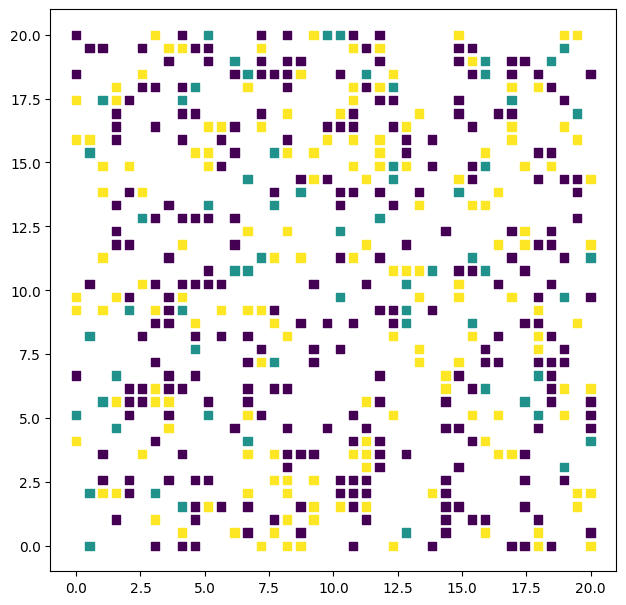

In [22]:
# %matplotlib notebook
plt.rcParams["figure.figsize"] = (7.3,7.3)
plt.scatter(
    c_x[cv_tr_bool | cv_ts_bool | ts_bool], 
    c_y[cv_tr_bool | cv_ts_bool | ts_bool], 
    c=(cv_tr_bool+ 2*cv_ts_bool + 3*ts_bool)[cv_tr_bool | cv_ts_bool | ts_bool], 
    label=(cv_tr_bool+ 2*cv_ts_bool + 3*ts_bool)[cv_tr_bool | cv_ts_bool | ts_bool],
    marker='s',
    # cmap='cool'
)
plt.show()


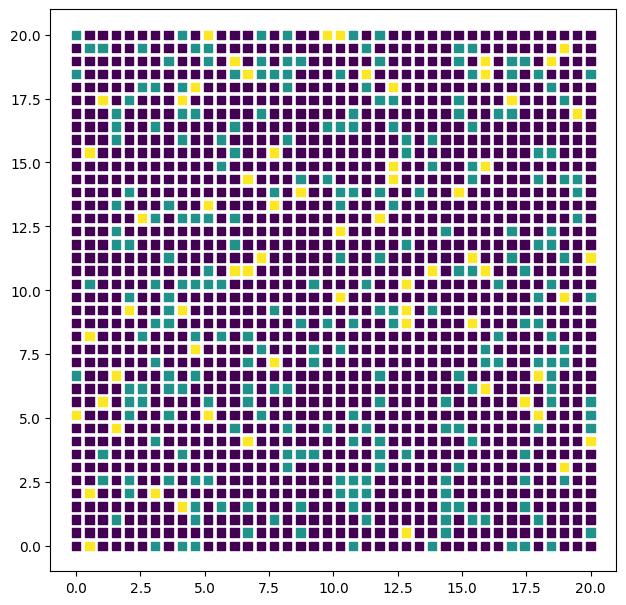

In [23]:
# %matplotlib notebook
plt.scatter(
    c_x, 
    c_y, 
    c=cv_tr_bool+ 2*cv_ts_bool, 
    label=cv_tr_bool+ 2*cv_ts_bool,
    marker='s'
)
plt.show()

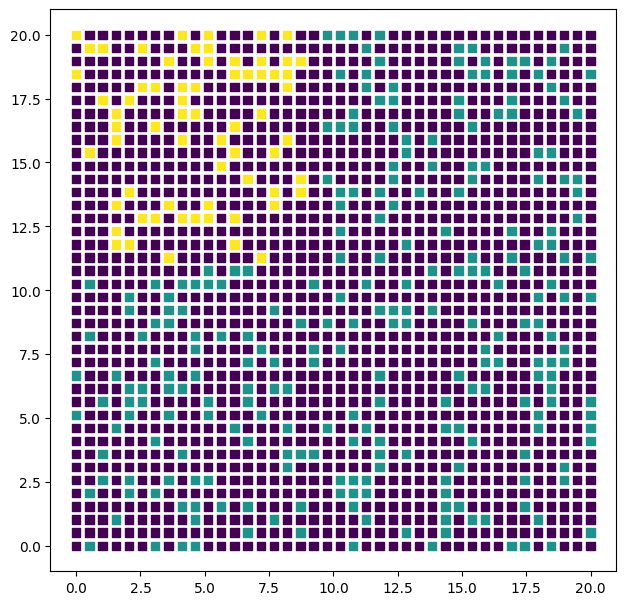

In [24]:
# %matplotlib notebook
plt.scatter(
    c_x, 
    c_y, 
    c=spcv_tr_bool+ 2*spcv_ts_bool, 
    label=spcv_tr_bool+ 2*spcv_ts_bool,
    marker='s'
)
plt.show()

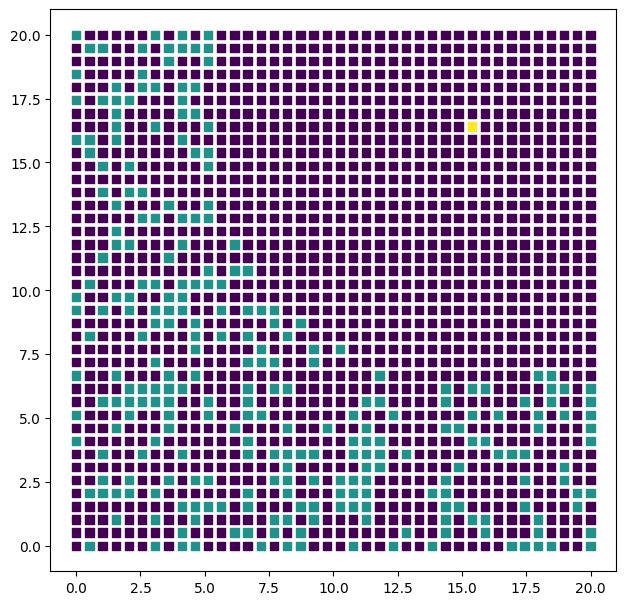

In [25]:
plt.scatter(
    c_x, 
    c_y, 
    c=bloocv_tr_bool+ 2*bloocv_ts_bool, 
    label=bloocv_tr_bool+ 2*bloocv_ts_bool,
    marker='s',
)
plt.show()

## Compute expected correction for one fold of CV vs expected correction for clustered sample

In [26]:
clus_kfcv_corr = np.zeros(100)
clus_spcv_corr = np.zeros(100)
clus_bloocv_corr = np.zeros(100)
clus_ns_corr = np.zeros(100)
clus_sp_corr = np.zeros(100)

for i in tqdm(range(100)):
    idxs, ts_idx = create_clus_split(
        nx,
        ny,
        .2,
        ngrid=10,
        ts_frac=.1,
        sort_grids=True,
    )
    ## randomize order for CV
    idxs = np.random.choice(idxs, size=len(idxs), replace=False)

    cv_tr_idx = idxs[:np.round(4*len(idxs)/5).astype(int)]
    cv_tr_bool = np.zeros(n, dtype=bool)
    cv_tr_bool[cv_tr_idx] = True

    cv_ts_idx = idxs[np.round(4*len(idxs)/5).astype(int):]#int(.4*n)]
    cv_ts_bool = np.zeros(n, dtype=bool)
    cv_ts_bool[cv_ts_idx] = True

    tr_idx = idxs#[:int(.4*n)]
    tr_bool = np.zeros(n, dtype=bool)
    tr_bool[tr_idx] = True

    # ts_idx = np.random.choice(not_test_idxs, size=int(.2*n), replace=False)
    ts_bool = np.zeros(n, dtype=bool)
    ts_bool[ts_idx] = True


    ## split into 3 folds by kmeans
    groups = KMeans(n_init=10, n_clusters=5).fit(coord[idxs]).labels_
    spcv_tr_idx = idxs[np.where(groups < 4)[0]]
    spcv_tr_bool = np.zeros(n, dtype=bool)
    spcv_tr_bool[spcv_tr_idx] = True
    spcv_ts_idx = idxs[np.where(groups == 4)[0]]
    spcv_ts_bool = np.zeros(n, dtype=bool)
    spcv_ts_bool[spcv_ts_idx] = True

    ## pick one point for ts, tr is all far enough away
    bloocv_tr_idx = idxs[np.random.choice(len(idxs),size=len(idxs),replace=False)]
    bloocv_ts_idx = bloocv_tr_idx[0]

    bloocv_tr_bool = np.zeros(n, dtype=bool)
    bloocv_tr_bool[bloocv_tr_idx] = True
    bloocv_tr_bool = getBufferTrain(D, bloocv_tr_bool, bloocv_ts_idx)

    bloocv_ts_bool = np.zeros(n, dtype=bool)
    bloocv_ts_bool[bloocv_ts_idx] = True

    # X = gen_rbf_X(c_x, c_y, p)
    X = gen_matern_X(c_x, c_y, p, length_scale=X_length_scale, nu=X_nu)
    Y = X@beta + Chol_t @ np.random.randn(n)
    
    X_cv = X[cv_tr_idx,:]
    S_cv = X[cv_ts_idx,:] @ np.linalg.pinv(X_cv)

    X_spcv = X[spcv_tr_idx,:]
    S_spcv = X[spcv_ts_idx,:] @ np.linalg.pinv(X_spcv)

    X_bloocv = X[bloocv_tr_bool,:]
    S_bloocv = X[bloocv_ts_idx,:] @ np.linalg.pinv(X_bloocv)

    
    X_tr = X[tr_idx,:]
    S_tr = X[ts_idx,:] @ np.linalg.pinv(X_tr)

    sp_idx = np.random.choice(ts_idx,size=1)
    sp_bool = np.zeros(n, dtype=bool)
    sp_bool[sp_idx] = True
    S_sp = X[sp_idx,:] @ np.linalg.pinv(X_tr)
    clus_kfcv_corr[i] = computeCorrection(S_cv, Sigma_t, cv_tr_bool, cv_ts_bool)
    clus_spcv_corr[i] = computeCorrection(S_spcv, Sigma_t, spcv_tr_bool, spcv_ts_bool)
    clus_bloocv_corr[i] = computeCorrection(S_bloocv, Sigma_t, bloocv_tr_bool, bloocv_ts_bool)
    clus_ns_corr[i] = computeCorrection(S_tr, Sigma_t, tr_bool, ts_bool)
    clus_sp_corr[i] = computeCorrection(S_sp, Sigma_t, tr_bool, sp_bool)

    # print(ts_bool.sum(), cv_tr_bool.sum(), cv_ts_bool.sum())
    
clus_corrs = pd.DataFrame({
    'KFCV': clus_kfcv_corr, 
    'SPCV': clus_spcv_corr, 
    'BLOOCV': clus_bloocv_corr, 
})


100%|██████████| 100/100 [00:04<00:00, 23.78it/s]


In [27]:
fig = gen_model_barplots(
    [[clus_ns_corr, clus_kfcv_corr, clus_spcv_corr, clus_bloocv_corr]], 
    [""], 
    est_names, 
    title="Spatial Train/Test Split: OLS Correction Term Comparisons", 
    has_elev_err=False
)
fig.show()